In [1]:
import torch
from peft import LoraConfig, get_peft_model
from model import NST
from encoder import print_trainable_parameters
from lossnet import *
from dataloader import PairedDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/louis/anaconda3/envs/NST/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
lora_config_c = lora_config_s = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["query", "value", "key", "dense"],
        lora_dropout=0.1,
        bias="none",
    )
# model = NST(lora_config_c=lora_config_c, lora_config_s=lora_config_s)
model = NST(freeze=True)
print(model)
print_trainable_parameters(model)

NST(
  (encoder_c): Encoder(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-5): 6 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTInterme

In [9]:
model.encoder_c = get_peft_model(model.encoder_c, lora_config_c)
model.encoder_s = get_peft_model(model.encoder_s, lora_config_s)
print_trainable_parameters(model)

trainable params: 34513731 || all params: 121056579 || trainable%: 28.51


In [14]:
feat = torch.randn(4, 3, 28, 28).view(4,3,-1)
print(feat.shape)
print((feat @ feat.transpose(1,2)).shape)
print((feat @ feat.transpose(1,2)))

torch.Size([4, 3, 784])
torch.Size([4, 3, 3])
tensor([[[815.1793,  26.8651, -45.3958],
         [ 26.8651, 768.5021, -30.5777],
         [-45.3958, -30.5777, 802.7254]],

        [[754.0264, -10.8973, -30.7464],
         [-10.8973, 820.4617,   9.6025],
         [-30.7464,   9.6025, 749.9842]],

        [[764.8160,   5.0449,  -9.9579],
         [  5.0449, 798.7611,  61.5847],
         [ -9.9579,  61.5847, 735.4014]],

        [[776.9156, -11.0372,  17.5655],
         [-11.0372, 770.0630,  20.4071],
         [ 17.5655,  20.4071, 796.9890]]])


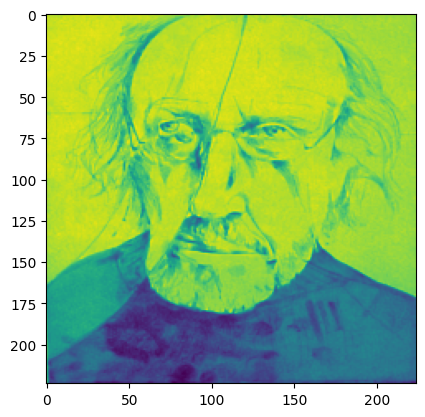

In [12]:
content_dir = "/data/louis/NST_dataset/COCO2014/"
style_dir = "/data/louis/NST_dataset/WikiArt_processed/"
dataset = PairedDataset(content_dir, style_dir)
dataloader = DataLoader(dataset, batch_size = 1, shuffle=True)
content, style = next(iter(dataloader))
plt.imshow(style[0,0])

In [5]:
vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features[:29]
num = 0
for p in vgg.parameters():
    if p.requires_grad:
        p.requires_grad_(False)
for p in vgg.parameters():
    if p.requires_grad:
        num += p.numel()
num

0

In [6]:
def calc_mean_std(feat):
    """
    #### input ####
    feat    : a feature output of a certain vgg layer, in shape [B, C, H, W]
    #### output ####
    mean    : in shape [B, C]
    std     : in shape [B, C]
    
    """
    B, C, H, W = feat.shape
    mean = feat.view(B, C, -1).mean(dim=2)
    std = feat.view(B, C, -1).std(dim=2)
    return mean, std

In [10]:
from torchvision.utils import save_image, make_grid
img_grid_contents = make_grid(torch.randn(16,3,28,28), normalize=True, nrow=4)
save_image(img_grid_contents, 'test.png')